In [20]:
import sys
! {sys.executable} -m pip install geopandas
! {sys.executable} -m pip install geoplot
! {sys.executable} -m pip install pysal

  Using cached geoplot-0.4.1-py3-none-any.whl (28 kB)
  Using cached mapclassify-2.3.0-py3-none-any.whl (35 kB)
  Using cached Cartopy-0.18.0.tar.gz (14.4 MB)
    ERROR: Command errored out with exit status 1:
     command: /opt/anaconda3/envs/cord19/bin/python -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/p2/vv6yr6g17m9cx0vzrrmg37xc0000gn/T/pip-install-w74jt6xx/cartopy/setup.py'"'"'; __file__='"'"'/private/var/folders/p2/vv6yr6g17m9cx0vzrrmg37xc0000gn/T/pip-install-w74jt6xx/cartopy/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /private/var/folders/p2/vv6yr6g17m9cx0vzrrmg37xc0000gn/T/pip-pip-egg-info-e292un1k
         cwd: /private/var/folders/p2/vv6yr6g17m9cx0vzrrmg37xc0000gn/T/pip-install-w74jt6xx/cartopy/
    Complete output (3 lines):
    /private/var/folders/p2/vv6yr6g17m9cx0vzrrmg37xc0000gn/T/pip-insta

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

import string
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%%time

my_spark = SparkSession .\
    builder .\
    appName("myApp") .\
    config("spark.mongodb.input.uri", "mongodb://13.76.131.54:27017/cord19dataset.fulltexts") .\
    config("spark.mongodb.output.uri", "mongodb://13.76.131.54:27017/cord19dataset.fulltexts") .\
    config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
    getOrCreate()

CPU times: user 45.9 ms, sys: 34.4 ms, total: 80.3 ms
Wall time: 14.5 s


In [3]:
%%time

fulltexts = my_spark.read.format("mongo").load()

CPU times: user 3.53 ms, sys: 3.09 ms, total: 6.62 ms
Wall time: 15.4 s


In [4]:
fulltexts.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- abstract: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- cite_spans: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- start: integer (nullable = true)
 |    |    |    |    |-- end: integer (nullable = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |-- ref_id: string (nullable = true)
 |    |    |-- ref_spans: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- start: integer (nullable = true)
 |    |    |    |    |-- end: integer (nullable = true)
 |    |    |    |    |-- text: string (nullable = true)
 |    |    |    |    |-- ref_id: null (nullable = true)
 |    |    |-- section: string (nullable = true)
 |    |    |-- text: string (nullable = true)
 |-- back_matter: array (nullable = true)
 |    |-- element: struct

In [5]:
%%time

institutions = fulltexts.select("metadata.authors.affiliation.institution").toPandas()

CPU times: user 543 ms, sys: 75.4 ms, total: 618 ms
Wall time: 24.5 s


In [6]:
institutions.head()

,institution
0,"[SARS Research Network, SARS Research Network,..."
1,"[University of North Carolina at Chapel Hill, ..."
2,"[None, None, None, None, None]"
3,"[University of North Carolina at Chapel Hill, ..."
4,"[None, None, None, None, None, None, None, Non..."


In [7]:
insts_count = {}

for insts in institutions['institution']:
    insts_set = set(insts)
    for inst in insts_set:
        if inst in insts_count.keys():
            insts_count[inst] += 1
        else:
            insts_count[inst] = 1

In [8]:
sorted_insts = {k: v for k, v in sorted(insts_count.items(), key=lambda item: item[1], reverse=True)}

In [9]:
sorted_insts

{None: 135266,
 '': 3738,
 'University of California': 880,
 'Chinese Academy of Sciences': 600,
 'Harvard Medical School': 538,
 'Huazhong University of Science and Technology': 505,
 'National Institutes of Health': 483,
 'University of Oxford': 453,
 'University of Washington': 425,
 'University of Toronto': 419,
 'The University of Hong Kong': 365,
 'University of Pennsylvania': 364,
 'Fudan University': 349,
 'Imperial College London': 330,
 'University College London': 293,
 'Stanford University': 292,
 'University of Michigan': 286,
 'University of Cambridge': 249,
 'Mayo Clinic': 239,
 'Columbia University': 236,
 'The Chinese University of Hong Kong': 228,
 'Wuhan University': 225,
 'National University of Singapore': 224,
 'Ministry of Health': 219,
 'University of Minnesota': 209,
 'Zhejiang University': 208,
 'Massachusetts General Hospital': 204,
 'Capital Medical University': 199,
 'University of British Columbia': 193,
 'University of Milan': 191,
 'Tehran University of 

In [10]:
countries = fulltexts.select("metadata.authors.affiliation.location.country").toPandas()

In [11]:
countries.head()

,country
0,"[None, None, None, None, None, None, None, Non..."
1,"[United States, United States, United States]"
2,"[None, None, None, None, None]"
3,"[None, None, None]"
4,"[None, None, None, None, None, None, None, Non..."


In [12]:
set(countries['country'][17102])

{'Republic of Korea'}

In [13]:
countries_count = {}

for couns in countries['country']:
    couns_set = set(couns)
    for coun in couns_set:
        if coun in countries_count.keys():
            countries_count[coun] += 1
        else:
            countries_count[coun] = 1

In [14]:
sorted_countries = {k: v for k, v in sorted(countries_count.items(), key=lambda item: item[1], reverse=True)}

In [15]:
sorted_countries

{None: 141920,
 'USA': 9621,
 'China': 6451,
 'Italy': 3759,
 'UK': 3247,
 'France': 2327,
 'Canada': 2233,
 'Germany': 2025,
 'Australia': 1885,
 'India': 1805,
 'Spain': 1669,
 'Japan': 1393,
 'United States': 1226,
 'United Kingdom': 1184,
 'Brazil': 1079,
 'Switzerland': 938,
 'The Netherlands': 891,
 'Iran': 810,
 'Belgium': 751,
 'Taiwan': 745,
 'United States of America': 688,
 'Sweden': 622,
 'Turkey': 560,
 'Singapore': 530,
 'Saudi Arabia': 521,
 'PR China': 482,
 'Korea': 459,
 "People's Republic of China": 443,
 'Poland': 438,
 'Israel': 429,
 'Greece': 403,
 'Republic of Korea': 402,
 'Denmark': 393,
 'South Africa': 346,
 'Austria': 343,
 'Ireland': 340,
 'Portugal': 314,
 'Malaysia': 310,
 'USA, USA': 305,
 'Egypt': 303,
 'Pakistan': 301,
 'China, China': 286,
 'the Netherlands': 280,
 'Finland': 269,
 'Thailand': 252,
 'Bangladesh': 224,
 'Norway': 201,
 'Russia': 199,
 'P.R. China': 197,
 'South Korea': 196,
 'Mexico': 196,
 'Nigeria': 193,
 'New Zealand': 191,
 'Argen

In [16]:
import json

with open('countries.json', 'w') as fp:
    json.dump(sorted_countries, fp)

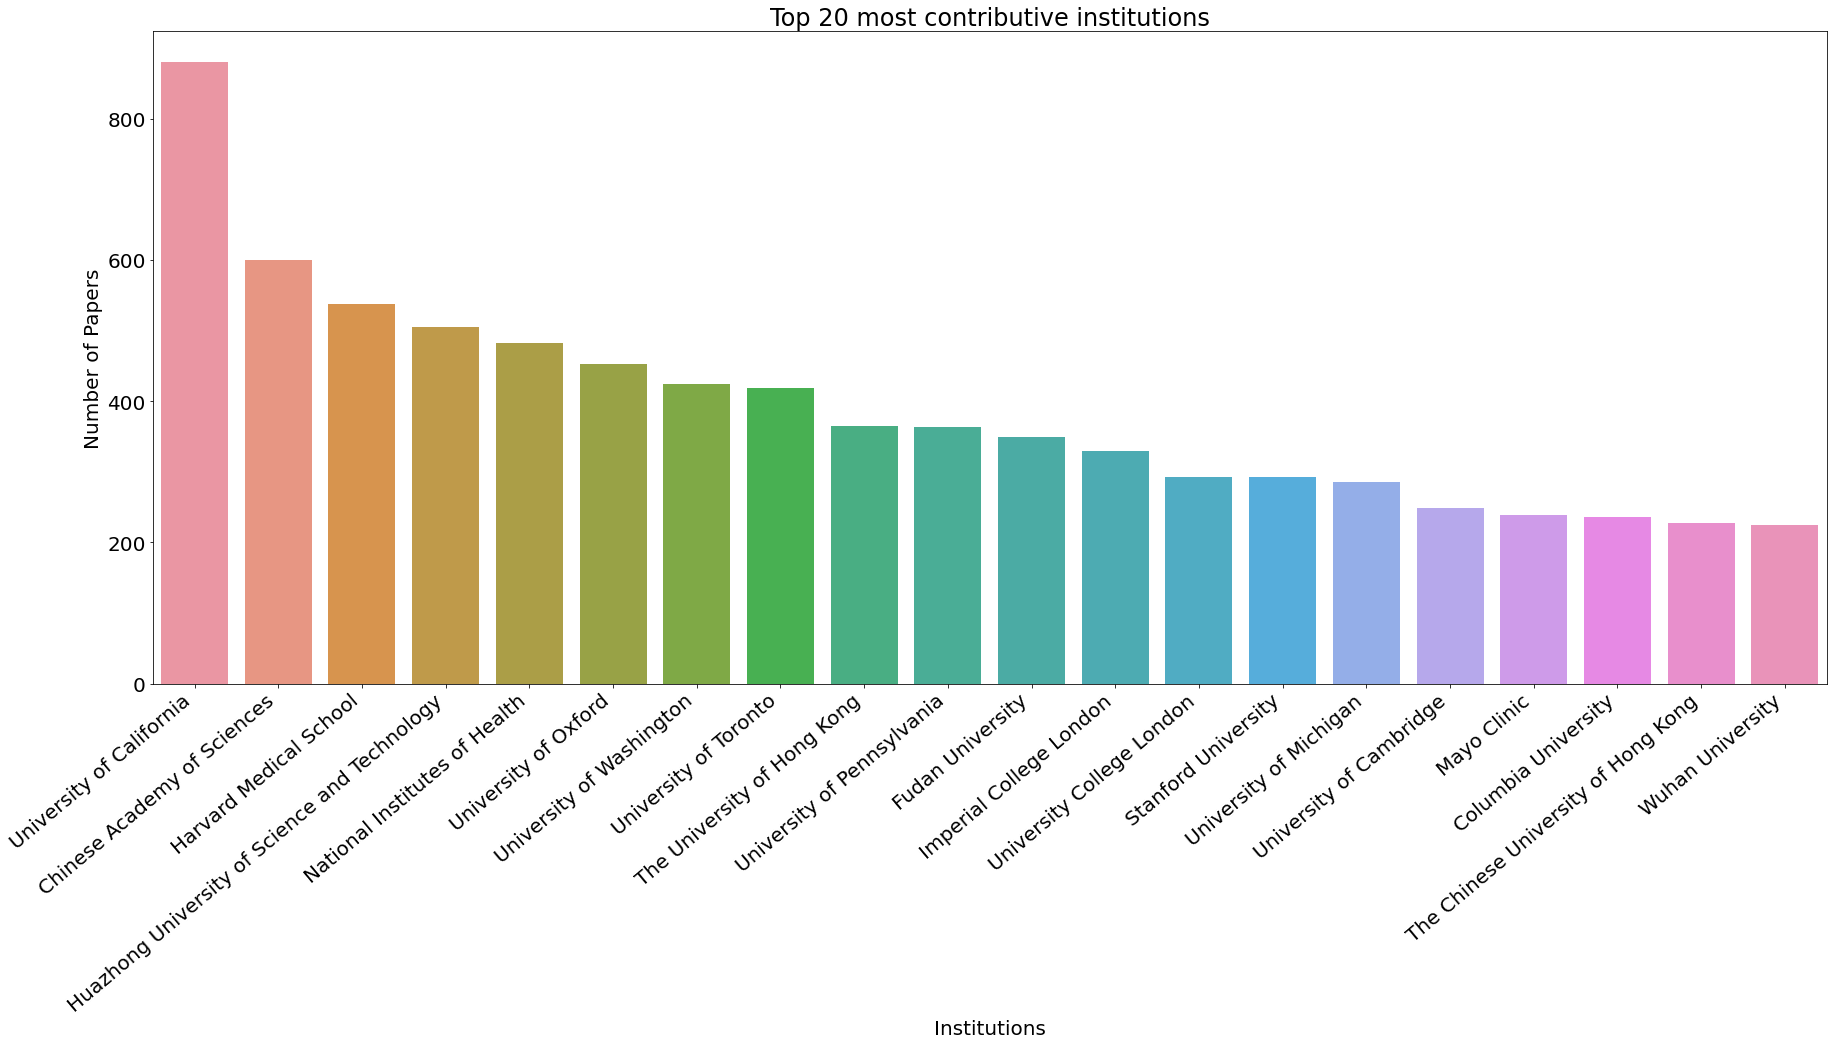

In [17]:
x = list(sorted_insts.keys())[2:22]
y = list(sorted_insts.values())[2:22]

font = {'size': 20}
plt.rc('font', **font)
plt.figure(figsize=(30,12))
plt.xlabel("Institutions")
plt.ylabel("Number of Papers")
plt.title("Top 20 most contributive institutions")
bar = sns.barplot(x=x,y=y)
bar.set_xticklabels(bar.get_xticklabels(), rotation=40, ha="right")
plt.savefig('top20institutions')
plt.show()